In [ ]:
from google.colab import drive
from google.colab import files 


drive.mount("/content/gdrive")
print(os.getcwd())
os.chdir("/content/gdrive/My Drive/AML2021/AML2021")
print(os.getcwd())

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os

import tensorflow as tf

from tensorflow.keras import backend, optimizers, models, applications, metrics
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, TensorBoard
import tensorflow.keras.utils as utils
from tensorflow import keras

In [2]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
generator = keras.models.load_model('models/GAN/best-Generator.hdf5')
generator.compile()

In [4]:
# Adapt Constants
date = time.strftime("%d-%m-%Y_%H-%M-%S")
MODEL_NAME = f"Synthetic-cGAN-EfficientNet-{date}"
os.makedirs(f'models/{MODEL_NAME}', exist_ok = True) 
INPUT_SHAPE = (299, 299, 3)
NUM_CLASSES = 2
INITIAL_EPOCH = 0
NUM_EPOCHS = 1000
OPTIMIZER = optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=False)
BATCH_SIZE = 16

class DataGeneratorGAN(tf.keras.utils.Sequence):
    def __init__(self, generator, batch_size=16):
      self.batch_size = batch_size
      self.generator = generator

    def __len__(self):
      return 100000

    def __getitem__(self, index):
      z = tf.random.normal(shape=(self.batch_size, 100))  # 100 latent dims in the GAN
      y = tf.one_hot(
          tf.random.uniform(shape=(self.batch_size, ), 
                            minval=0, 
                            maxval=2, 
                            dtype=tf.int32),
                     depth=2, dtype=tf.int32)
      X = self.generator([z, y])
      return X, y

    def on_epoch_end(self):
        pass

data_generator = DataGeneratorGAN(generator=generator, batch_size=BATCH_SIZE)

LRS = ReduceLROnPlateau(monitor='val_auroc', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001)
ES = EarlyStopping(monitor='val_auroc', min_delta=0.0001, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=False)


MC = ModelCheckpoint(f'models/{MODEL_NAME}/latest-{MODEL_NAME}.hdf5', monitor='val_auroc', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq="epoch")
MC_BEST = ModelCheckpoint(f'models/{MODEL_NAME}/best-{MODEL_NAME}.hdf5', monitor='val_auroc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")
LOG = CSVLogger(f'models/{MODEL_NAME}/{MODEL_NAME}.log')
TB = TensorBoard(log_dir=f'models/{MODEL_NAME}/logs')

METRICS = [metrics.AUC(name='auroc', curve='ROC'),
           metrics.CategoricalAccuracy(name='accuracy'),
           metrics.Precision(name='precision'),
           metrics.Recall(name='recall')
           ]

# Load data
assert(backend.image_data_format()=='channels_last')

# Model: preprocess, base model, top layer/classifier
i = Input(shape=INPUT_SHAPE)
x = applications.efficientnet.preprocess_input(i)


base_model = applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet", input_shape=INPUT_SHAPE)
x = base_model(x)

x = GlobalAveragePooling2D(name='avg_pool')(x)
o = Dense(NUM_CLASSES, activation='softmax', name=f'fc{NUM_CLASSES}')(x)

model = models.Model(inputs=i, outputs=o)

# Train Model
if INITIAL_EPOCH != 0:
	model = models.load_model(f'models/{MODEL_NAME}/latest-{MODEL_NAME}.hdf5', compile=True)
else:
  model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=METRICS)



In [ ]:
model.fit(
    data_generator,
    steps_per_epoch = 100,
    callbacks = [MC, MC_BEST, LRS, LOG, TB], 
    validation_data = data_generator, 
    validation_steps = 10,
    epochs = NUM_EPOCHS
    )

In [6]:
# Eval Model
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

model = models.load_model(f'models/Synthetic-cGAN-EfficientNet-26-09-2021_15-42-21/latest-Synthetic-cGAN-EfficientNet-26-09-2021_15-42-21.hdf5', compile=True)
out = model.evaluate(x=x_test, y=y_test, batch_size=BATCH_SIZE, verbose=1)

# Save Results
with open("results.txt","a+") as f:
  f.write(f"{MODEL_NAME} test_loss: {out[0]}, test_auroc: {out[1]}, test_acc: {out[2]}, test_prec: {out[3]}, test_rec: {out[4]}, test_f1: {2* ((out[3]*out[4]) / (out[3]+out[4]))}\n")
print(f"wrote \"{MODEL_NAME} test_loss: {out[0]}, test_auroc: {out[1]}, test_acc: {out[2]}, test_prec: {out[3]}, test_rec: {out[4]}, test_f1: {2* ((out[3]*out[4]) / (out[3]+out[4]))}\n\" to results.txt ")

173/173 [==============================] - 28s 123ms/step - loss: 0.7505 - auroc: 0.1967 - accuracy: 0.2617 - precision: 0.2617 - recall: 0.2617
wrote "Synthetic-cGAN-EfficientNet-30-09-2021_11-16-27 test_loss: 0.7505400776863098, test_auroc: 0.19665676355361938, test_acc: 0.26167210936546326, test_prec: 0.26167210936546326, test_rec: 0.26167210936546326, test_f1: 0.26167210936546326
" to results.txt 


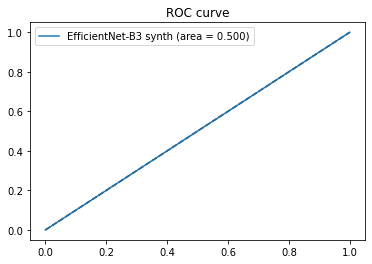

In [10]:
#Plot ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = auc(fpr, tpr)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='EfficientNet-B3 synth (area = {:.3f})'.format(auc))
#plt.xlabel('False positive rate')
#plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("cGAN-synthetic.png")
plt.show()